### Teleportación Cuántica

In [ ]:
#Para instalar las librerías necesarias

!pip install qiskit
!pip install qiskit_aer
!pip install qiskit_ibm_runtime
!pip install matplotlib
!pip install pylatexenc
!pip install prototype-zne

Importamos las librerías de interés. QISKit es una librería de IBM para python en la cual podemos ejecutar circuitos tanto en simuladores como en computadoras cuánticas reales.

Note: you may need to restart the kernel to use updated packages.


In [1]:
from qiskit import *
# from qiskit import IBMQ en qiskit 1.0 no hace falta
# do pip install qiskit-ibm-runtime first
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

In [3]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.primitives import StatevectorSampler, PrimitiveJob
from qiskit.circuit.library import TwoLocal
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_aer import AerSimulator, QasmSimulator

In [4]:
### Save API Token, if needed

%set_env QXToken=4d51da0de26afa73110cc552b49028c2f1cee86c63a04ece2c248fb437a99528915c1a642c14453659dad40783ce6ebab84c63ab7416c1a3552748ee40b863ca#Copiar el token aquí

# Or save your credentials on disk.

# from qiskit_ibm_runtime import QiskitRuntimeService

# service = QiskitRuntimeService(
#     channel='ibm_quantum',
#     instance='events/qc-2024-17/project-1',
#     token='6de5d478db5e5ced14129f1fe6c1a405690f788fe796d90e20270c6ddb14e2ff88cfea43a62afd2c3d821a0099e25454ab1d2928cb95d0549b18555b7bcbfab1'
# )

# Or save your credentials on disk.
# QiskitRuntimeService.save_account(channel='ibm_quantum', instance='events/qc-2024-17/project-1', token='ff6d9d4d8fd0351d415becd39c3e7550f6777ede724647bf14d877fdf4ec070af849c29762944dcc228b6b04833569e80ca483a5e66d201e1a8af42e66208eb7')

# Or save your credentials on disk.
# QiskitRuntimeService.save_account(channel='ibm_quantum', instance='ibm-q/open/main', token='ff6d9d4d8fd0351d415becd39c3e7550f6777ede724647bf14d877fdf4ec070af849c29762944dcc228b6b04833569e80ca483a5e66d201e1a8af42e66208eb7')


# Make sure there is no space between the equal sign
# and the beginning of your token

env: QXToken=4d51da0de26afa73110cc552b49028c2f1cee86c63a04ece2c248fb437a99528915c1a642c14453659dad40783ce6ebab84c63ab7416c1a3552748ee40b863ca#Copiar el token aquí


Creamos un circuito donde el primer qubit (qubit[0]) será el qubit que deseamos transmitir (Alice), el segundo qubit (qubit[1]) lo utilizaremos como auxiliar y el tercer qubit (qubit[2]) será el qubit que consideraremos como destino (Bob).

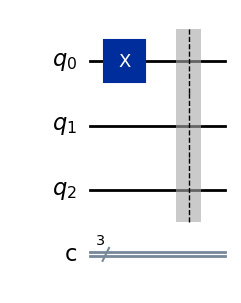

In [4]:
# Creamos un circuitos cuántico que cuente con 3 bits cuánticos (qubits) y 3 bits clásicos (registros)
circuit = QuantumCircuit(3,3)

# Aplico una compuerta Hadamard al primer qubits para crear el estado cuántico 
# que deseo transmitir, en este caso el estado |1>
circuit.x(0) 

# La barrera sirve exclusivamente para separar el circuito en partes
circuit.barrier() 

# Visualizamos el circuito hasta el momento
circuit.draw("mpl")

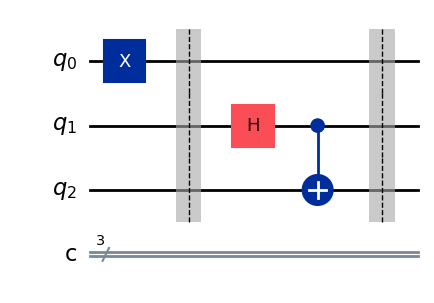

In [5]:
# Creo el estado de Bell entre # Creo el estado de Bell entre 
# Alice y el qubit auxiliar
circuit.h(1)
circuit.cx(1,2)

# La barrera sirve exclusivamente para separar el circuito en partes
circuit.barrier() 

# Visualizamos el circuito hasta el momento
circuit.draw("mpl")

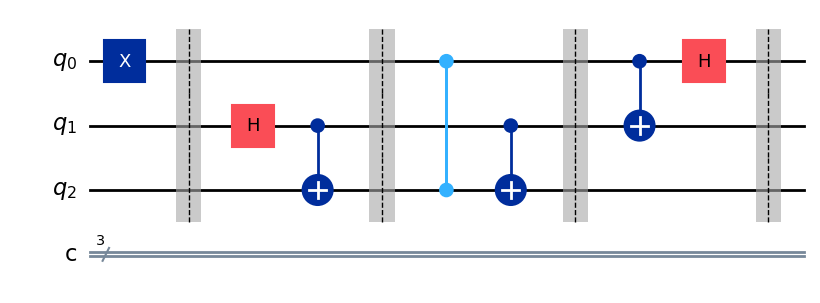

In [9]:
# Coloco las compuertas para crear el circuito de teleportación
circuit.cx(0,1)
circuit.h(0)

# La barrera sirve exclusivamente para separar el circuito en partes
circuit.barrier() 

# Visualizamos el circuito hasta el momento
circuit.draw("mpl")

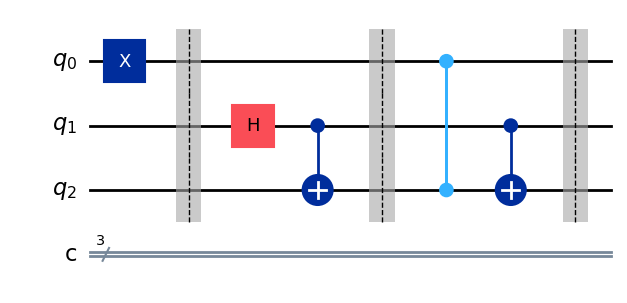

In [6]:
# Aplico la computerta X a Bob si el valor de Alice es 1 y la compuerta X a Bob  
# si el valor del qubit auxiliar es 1
circuit.cz(0, 2)
circuit.cx(1, 2)

# La barrera sirve exclusivamente para separar el circuito en partes
circuit.barrier() 

# Visualizamos el circuito hasta el momento
circuit.draw("mpl")

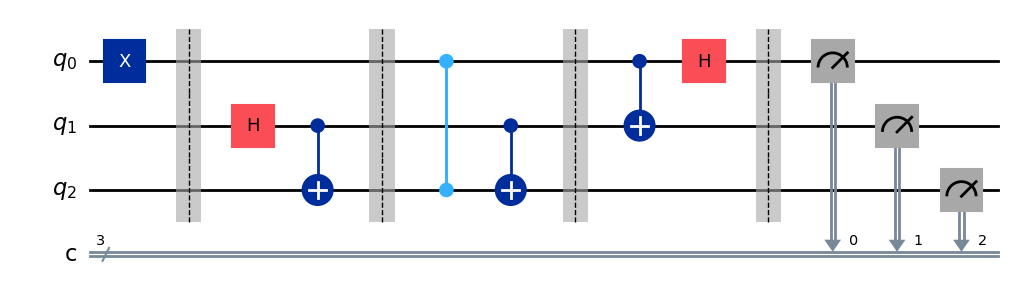

In [10]:
# Aplico las mediciones al final del circuito para los 3 qubits guardo sus 
# mediciones en los registros clásicos
circuit.measure([0, 1, 2], [0, 1, 2]) 

# Visualizamos el circuito hasta el momento
circuit.draw("mpl")

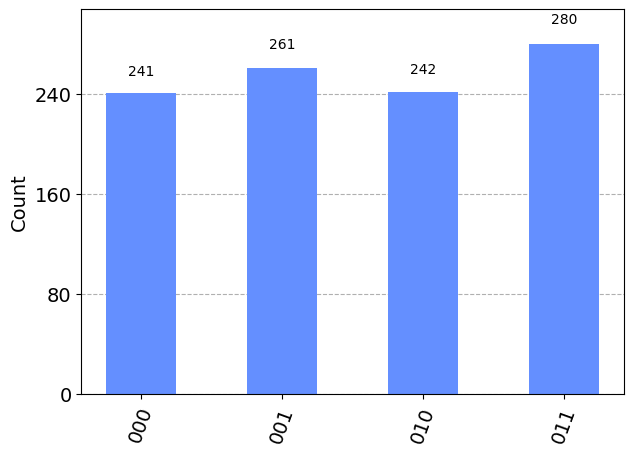

In [11]:
# Asigno el dispositivo en el cual voy a implementar mi circuito, en este caso,
# voy a implementarlo en el 'qasm_simulator' 
# Defino la ejecución y le asigno la cantidad de veces que se va a ejecutar 
# circuito (1024 en este caso)

backend = QasmSimulator()
job = backend.run(circuit, shots=1024)
counts = job.result().get_counts()

plot_histogram(counts)

In [12]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_sherbrooke'

In [14]:
# For execution

compiled_circuit = transpile(circuit, backend)
sim_result = backend.run(compiled_circuit).result()
counts = sim_result.get_counts()

/tmp/ipykernel_65901/2941326394.py:4: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  sim_result = backend.run(compiled_circuit).result()


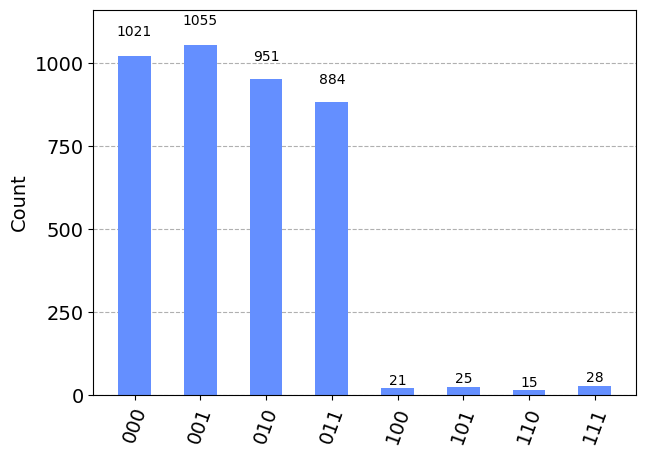

In [15]:
plot_histogram(counts)

Los resultados son interesantes y es adecuado hacer un análisis: si bien el comportamiento general de los sistemas es similar en ambos casos, podemos ver que en el caso del simulador vemos el estado del bit más significativo (mediciones del tercer qubit) es 1 en todos los casos. Esto ocurre ya que el estado que deseabamos transmitir era el |1>. Por lo tanto evidenciamos que la transmición es perfecta en el 100% de los casos.

Sin embargo, en el caso que implementamos el circuito en una computadora cuántica real vemos casos en los cuales el bit más significativo es 0, los cual quiere decir que la transferencia falla. Esto ocurre ya que estamos trabajando con una computadora cuántica real con errores que se producen debido a problemas a la hora de aislar el sistema. Estos problemas técnicos producen la decoherencia del sistema y hacen que en algunos casos el circuito falle.

Como conclusión, es interesante destacar como con pocas lineas de código podemos implementar facilmente un circuito en una computadora cuántica real y estudiar su comportamiento.